# Playing with coupled oscillators

This notebook builds on previous notebooks such as Orbit_games.ipynb to implement the solution of linear coupled differential equations using `solve_ivp` as well as with more analytic methods.  The formalism and notation is based on Taylor, Chapter 11: *Coupled Oscillators and Normal Modes*.

The general form of the equations to solve is compactly expressed in matrix form:

$\begin{align}
  \mathbf{M} \mathbf{\ddot q} = - \mathbf{K} \mathbf{q}
\end{align}$

where $\mathbf{M}$ and $\mathbf{K}$ are $N \times N$ symmetric matrices and $\mathbf{q}$ is a vector of generalized coordinates (this is $\mathbf{x}$ in the beginning discussion in Taylor).  

We can solve this directly as differential equations or solve for normal modes.  For the former, we map the problem onto linear differential equations and the vectors $\mathbf{y}$ and $d\mathbf{y}/dt$, which are each of length $2N$.  Here is the $N=2$ mapping:

$\begin{align}
  \mathbf{y} = \left( \begin{array}{c}
                         q_1 \\
                         q_2 \\
                         \dot q_1 \\
                         \dot q_2
                      \end{array}   
                       \right)
 \qquad\qquad
\frac{d\mathbf{y}}{dt} = \left( \begin{array}{c}
                         \dot q_1 \\
                         \dot q_2 \\
                         \ddot q_1 \\
                         \ddot q_2
                      \end{array}   
                       \right)
\end{align}$

Then for the $\ddot q$ parts we use the matrix solution of our equation:

$\begin{align}
  \mathbf{\ddot q} = - \mathbf{M}^{-1} \mathbf{K} \mathbf{q}
\end{align}$

where $\mathbf{M}^{-1}$ means the matrix inverse.  Check out the implementation below!

To solve for normal modes, we solve the generalized eigenvalue problem

$\begin{align}
  (\mathbf{K} - \omega^2 \mathbf{M}) \mathbf{a} = 0
\end{align}$

using functions from `scipy.linalg` to find the eigenvalues and eigenvectors.  We use these below together with the numerical solutions to make plots of the normal modes.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import linalg as LA 

In [5]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [6]:
class CoupledOscillators:
    """
    Solve the equations for linear coupled oscillators in matrix formulation.
    """
    
    def __init__(self, M_matrix, K_matrix):
        self.M_matrix = M_matrix
        self.K_matrix = K_matrix
        self.q_len = len(self.M_matrix)
        self.full_matrix = np.zeros((self.q_len, self.q_len))
        
            
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dq_vec/dt d^2q_vec/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            vector with y[0:q_size] = q_vec, y[q_size:] = dqvec/dt
            
        """
        dy_dt_vec = np.zeros(2*self.q_len)   # initialize to twice q_vec size
        dy_dt_vec[:self.q_len] = y[self.q_len:]  
        dy_dt_vec[self.q_len:] = -1.* LA.inv(self.M_matrix) @ \
                                      self.K_matrix @ y[:self.q_len]
        return dy_dt_vec
    
    
    def solve_ode(self, t_pts, q_vec_0, q_vec_dot_0,
                  method='RK45',
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        y = np.concatenate((q_vec_0, q_vec_dot_0))
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        q_vec, q_vec_dot = np.array_split(solution.y, 2)
        return q_vec, q_vec_dot
    

    def find_eigenmodes(self):
        """
        Find the normal modes.
        """
        eig_vals, eig_vecs = LA.eigh(K_matrix, M_matrix)
        self.frequencies = np.sqrt(eig_vals)
        return eig_vals, eig_vecs

In [7]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Section 11.2

In [8]:
m = 1.
M_matrix = np.array([ [m, 0.], [0., m] ])
print('M matrix: \n', M_matrix, '\n')

k = 1.
K_matrix = np.array([ [2.*k, -k], [-k, 2.*k]])
print('K matrix: \n', K_matrix, '\n')

co1 = CoupledOscillators(M_matrix, K_matrix)

eig_vals, eig_vecs = co1.find_eigenmodes() # LA.eigh(K_matrix, M_matrix)

print(f'omega^2 = {eig_vals}')
print(f'frequencies = {co1.frequencies}')

M matrix: 
 [[1. 0.]
 [0. 1.]] 

K matrix: 
 [[ 2. -1.]
 [-1.  2.]] 

omega^2 = [1. 3.]
frequencies = [1.         1.73205081]


In [9]:
print(eig_vecs[:,0])
print(eig_vecs[:,1])

[-0.70710678 -0.70710678]
[-0.70710678  0.70710678]


In [11]:
t_start = 0.
t_end = 10.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

In [12]:
print(co1.q_len)

2


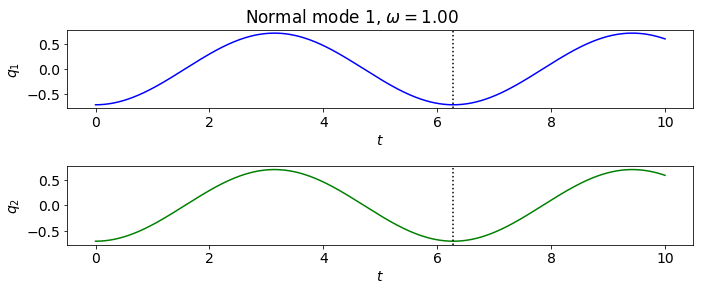

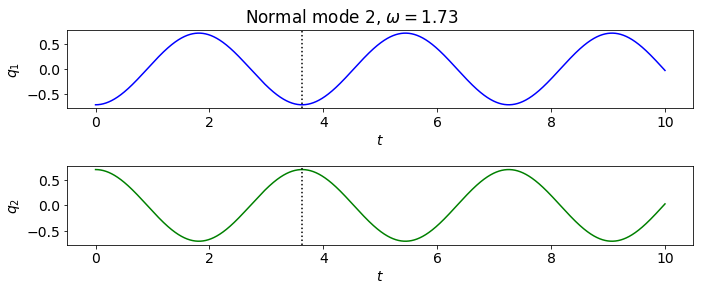

In [15]:
colors = ['blue', 'green', 'red', 'purple']

for i in np.arange(co1.q_len): 
   q_vec_0 = eig_vecs[:,i] 
   q_vec_dot_0 = np.zeros(co1.q_len)  
   q_vec, q_vec_dot = co1.solve_ode(t_pts, q_vec_0, q_vec_dot_0)
    
   fig, axes = plt.subplots(co1.q_len, 1, figsize=(10, 2.*co1.q_len))
   for j in np.arange(co1.q_len):
      axes[j].plot(t_pts, q_vec[j], color=colors[j])
      axes[j].set_xlabel(r'$t$')
      axes[j].set_ylabel(fr'$q_{j+1:d}$')
      axes[j].axvline(2.*np.pi/np.sqrt(eig_vals[i]), 
                      color='black', linestyle=':')
   fig.suptitle(fr'Normal mode {i+1:d}, $\omega = {co1.frequencies[i]:.2f}$', 
                va='center')
   fig.tight_layout()




In [ ]:
# Step through the eigenvalues